In [106]:
from prophet import Prophet
from neuralprophet import NeuralProphet
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from scipy.stats import boxcox
from pmdarima import auto_arima

from sklearn.model_selection import train_test_split, cross_val_score, ParameterGrid, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, ARDRegression
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, RegressorMixin

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.datasets.danish_data import load
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.ardl import ardl_select_order

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm
plt.style.use('ggplot')
pd.options.display.float_format = '{:.2f}'.format

In [107]:
import os
os.chdir('/Users/askar/Desktop/ВКР/Diploma.-Inflation-model-using-PCA')
os.getcwd()

'/Users/askar/Desktop/ВКР/Diploma.-Inflation-model-using-PCA'

In [143]:
# df = pd.read_csv('processed_regional_data/infl_rus.csv')
# df['date'] = pd.date_range(start='2014-01-01', periods=len(df), freq='M')
# df_train = df[df['date'] < '2022-02-01'].copy()
# df_test = df[df['date'] >= '2022-02-01'].copy()
# df_test

In [147]:
split_date = '2022-08-01'

df = pd.read_csv('processed_regional_data/infl_rus.csv')
df['date'] = pd.date_range(start='2014-01-01', periods=len(df), freq='M')
df_1 = df.loc[df['date'] < split_date].copy()
df_2 = df.loc[df['date'] >= split_date].copy()

quantile_99 = df_1['inflation'].quantile(0.96)
df_1.loc[df_1['inflation'] >= quantile_99, 'inflation'] = quantile_99
quantile_99 = df_2['inflation'].quantile(0.95)
df_2.loc[df_2['inflation'] >= quantile_99, 'inflation'] = quantile_99

df_3 = pd.concat([df_1, df_2])
df_train = df_3[df_3['date'] < split_date].copy()
df_test = df_3[df_3['date'] >= split_date].copy()

In [148]:
y_train = df_train['inflation']
y_test = df_test['inflation']
df_train.drop(['inflation', 'date'], axis=1, inplace=True)
df_test.drop(['inflation', 'date'], axis=1, inplace=True)
X_train = df_train.copy()
X_test = df_test.copy()

## ARDL


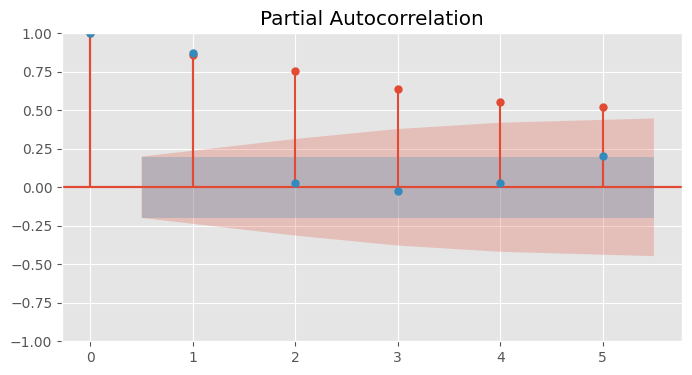

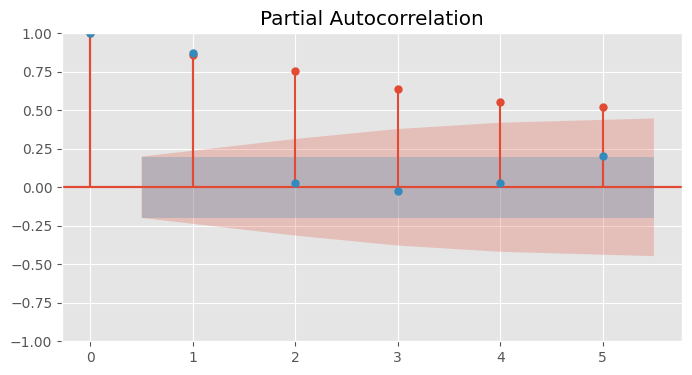

In [111]:
plt.figure(figsize=(8, 4))
plot_acf(y_train, lags=5, ax=plt.gca())
plot_pacf(y_train, lags=5, ax=plt.gca(), method='ols')

In [112]:
# Построение ARDL модели
ardl = sm.tsa.AutoReg(endog=y_train, exog=X_train, lags=1)
ardl_fitted = ardl.fit()
result = ardl_fitted.summary()
print(result)

# forecast = ardl_fitted.predict(start=len(y_train), end=len(y_train)+len(X_test)-1, exog=X_test)

                            AutoReg Model Results                             
Dep. Variable:              inflation   No. Observations:                   97
Model:                   AutoReg-X(1)   Log Likelihood                  57.826
Method:               Conditional MLE   S.D. of innovations              0.132
Date:                Sun, 20 Apr 2025   AIC                            -83.653
Time:                        17:58:14   BIC                            -42.623
Sample:                             1   HQIC                           -67.068
                                   97                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0730      0.028      2.646      0.008       0.019       0.127
inflation.L1      0.8383      0.049     17.079      0.000       0.742       0.935
debt_firms       -0.0164      0.059     

## Prophet


17:58:14 - cmdstanpy - INFO - Chain [1] start processing
17:58:15 - cmdstanpy - INFO - Chain [1] done processing


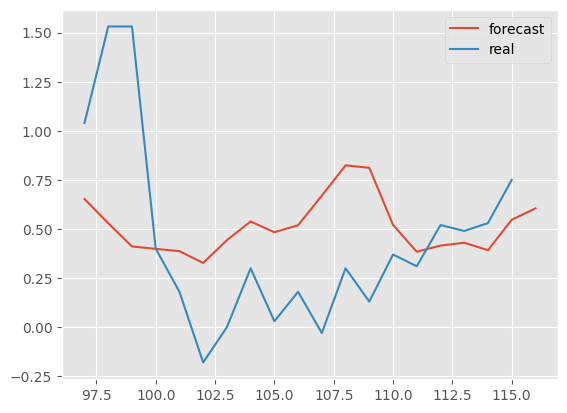

In [113]:
df_prophet = df.loc[:97, ['date', 'inflation']].copy()
df_prophet.columns = ['ds', 'y']
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

prophet_model = Prophet(interval_width=0.95)
prophet_model.fit(df_prophet)
future = prophet_model.make_future_dataframe(periods=len(y_test), freq='M')
prophet_pred = prophet_model.predict(future)
prophet_pred.iloc[-20:]['yhat'].plot(label='forecast')
y_test.plot(label='real')
plt.legend()

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to [98.98]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 8
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 250


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (13) is too small than the required number                     for the learning rate finder (207). The results might not be optimal.
Finding best initial lr: 100%|██████████| 207/207 [00:02<00:00, 93.01it/s] 


Training: |          | 0/? [00:35<?, ?it/s, v_num=6, train_loss=0.0472, reg_loss=0.000, MAE=0.137, RMSE=0.223, Loss=0.0446, RegLoss=0.000]

INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to [98.98]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neuralprophet/data/split.py:273: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, future_df])

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to [99.145]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO - (NP.df_utils._infer_frequency) - Major frequency M corresp


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 45.56it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


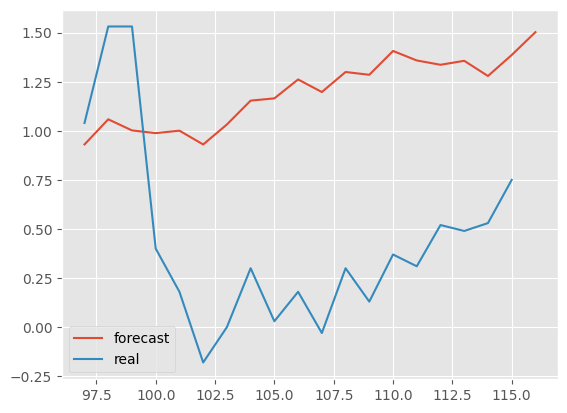

In [114]:
nprophet_model = NeuralProphet()
metrics = nprophet_model.fit(df_prophet, freq="M")
future_df = nprophet_model.make_future_dataframe(df_prophet,
                                                 periods=len(y_test),
                                                 n_historic_predictions=len(df_prophet))
preds_df_2 = nprophet_model.predict(future_df)

preds_df_2.iloc[-20:]['yhat1'].plot(label='forecast')
y_test.plot(label='real')
plt.legend()

## SARIMA


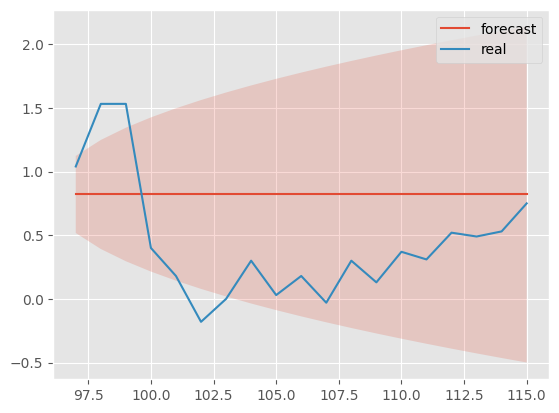

In [115]:
sarima = auto_arima(y_train, seasonal=True, m=6, stepwise=True)
sarima_forecast = sarima.predict(n_periods=len(y_test), return_conf_int=True)
sarima_pred, sarima_conf_int = sarima_forecast[0], sarima_forecast[1]

sarima_pred.plot(label='forecast')
y_test.plot(label='real')
plt.legend()
plt.fill_between(range(97, 97+len(y_test)),
                 sarima_conf_int[:, 0], sarima_conf_int[:, 1], alpha=0.2)

## ETS


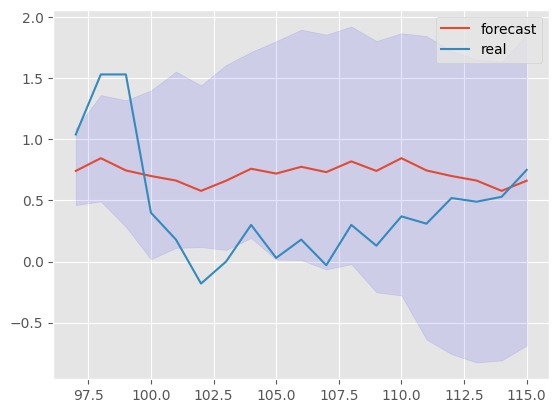

In [116]:
ets = ExponentialSmoothing(y_train, seasonal='add', seasonal_periods=12).fit()
ets_forecast = ets.forecast(len(y_test))
num_simulations = 5000
confidence_interval = .95
simulated_forecasts = np.array(
    [ets.simulate(len(y_test)) for _ in range(len(y_test))])
lower_bound = np.percentile(
    simulated_forecasts, (1 - confidence_interval) / 2 * 100, axis=0)
upper_bound = np.percentile(
    simulated_forecasts, (1 + confidence_interval) / 2 * 100, axis=0)
ets_conf_int = np.array(list(zip(lower_bound, upper_bound)))

ets_forecast.plot(label='forecast')
y_test.plot(label='real')
plt.legend()
plt.fill_between(range(97, 97+len(y_test)),
                 ets_conf_int[:, 0], ets_conf_int[:, 1], alpha=0.1, color='blue');

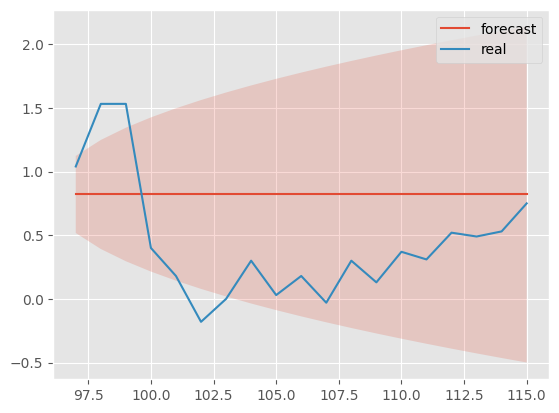

In [117]:
sarima = auto_arima(y_train, seasonal=False, stepwise=True)
sarima_forecast = sarima.predict(n_periods=len(y_test), return_conf_int=True)
sarima_pred, sarima_conf_int = sarima_forecast[0], sarima_forecast[1]

sarima_pred.plot(label='forecast')
y_test.plot(label='real')
plt.legend()
plt.fill_between(range(97, 97+len(y_test)),
                 sarima_conf_int[:, 0], sarima_conf_int[:, 1], alpha=0.2)

## STL + ARIMA


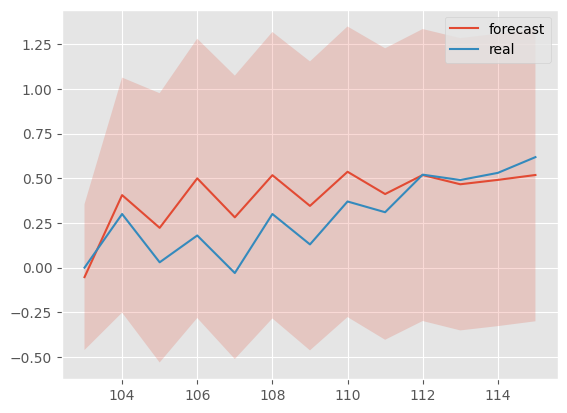

In [149]:
from statsmodels.tsa.seasonal import STL
raw_data = pd.read_csv('regional_data/infl_Российская_Федерация.csv')
# a_train = raw_data.iloc[:97]['inflation']
# a_test = raw_data.iloc[97:]['inflation']

a_train = y_train.copy()
a_test = y_test.copy()

# удаляем сезонность в тренировочных данных
stl = STL(a_train, period=2)
res = stl.fit()
# Моделируем АРИМУ на тренировочных данных
arima_model = auto_arima((res.trend + res.resid),
                         seasonal=False, stepwise=True)
# Удаляем сезонность в тестовых данных
stl = STL(a_test, period=2)
res = stl.fit()
# Предсказываем значения с помощью модели
arima_forecast = arima_model.predict(
    n_periods=len(a_test), return_conf_int=True)
# Корректируем предсказание, добавляя сезонную компоненту
stl_arima_pred = arima_forecast[0] + res.seasonal[-len(a_test):]
num = a_test
# CI создаем массив для графика
stl_arima_conf_int = np.column_stack([
    arima_forecast[1][:, 0] + res.seasonal.values,
    arima_forecast[1][:, 1] + res.seasonal.values
])


stl_arima_pred.plot(label='forecast')
a_test.plot(label='real')
plt.legend()
plt.fill_between(a_test.index,
                 stl_arima_conf_int[:, 0],
                 stl_arima_conf_int[:, 1],
                 alpha=0.2)

## XGBoost


Mean Squared Error: 0.2088
Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


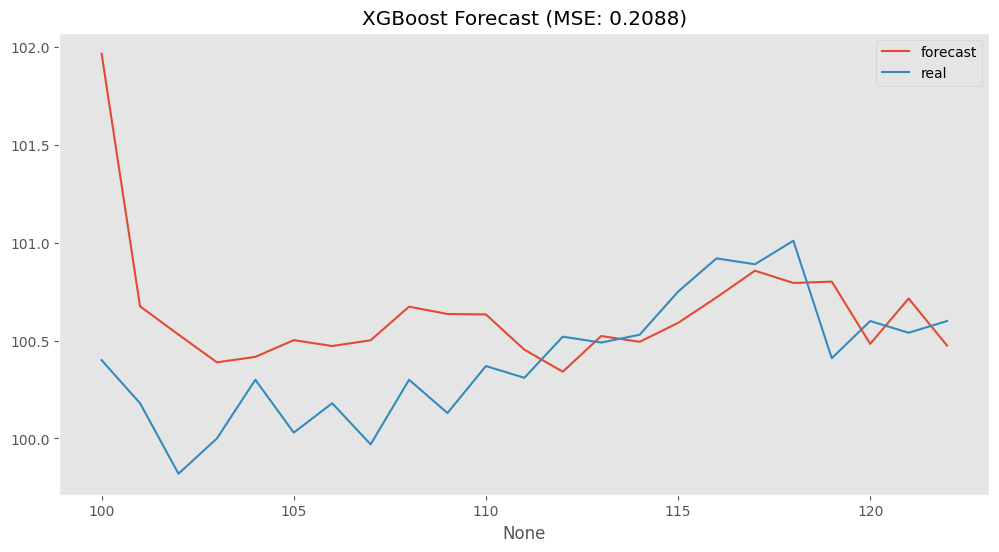

In [138]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

def create_features(df, target_col='inflation', n_lags=3, window_size=3):
    """
    Создает временные признаки для модели:
    - Лаги (авторегрессионная компонента)
    - Скользящие статистики
    - Временные фичи из даты
    """
    df = df.copy()
    
    # 1. Авторегрессионные компоненты (лаги)
    for lag in range(1, n_lags+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    
    # 2. Скользящие статистики
    df['rolling_mean'] = df[target_col].rolling(window=window_size).mean().shift(1)
    df['rolling_std'] = df[target_col].rolling(window=window_size).std().shift(1)
    
    # 3. Временные фичи из даты
    df['month'] = df['ds'].dt.month
    df['quarter'] = df['ds'].dt.quarter
    df['year'] = df['ds'].dt.year
    df['days_in_month'] = df['ds'].dt.days_in_month
    
    # 4. Дополнительные преобразования
    df['time_idx'] = (df['ds'] - df['ds'].min()).dt.days
    
    return df.dropna()
# Загрузка данных
raw_data = pd.read_csv('regional_data/infl_Российская_Федерация.csv')
a_train = pd.DataFrame(raw_data.iloc[:97]['inflation'])
a_test = pd.DataFrame(raw_data.iloc[97:]['inflation'])

# Добавляем даты
a_train['ds'] = pd.date_range(start='2014-01-01', freq='M', periods=97)
a_test['ds'] = pd.date_range(start='2022-01-01', freq='M', periods=26)

# Создаем фичи для train и test
train_feats = create_features(a_train)
test_feats = create_features(a_test)

# Разделяем на X и y
X_train_1 = train_feats.drop(columns=['inflation', 'ds'])
y_train_1 = train_feats['inflation']

X_test_1 = test_feats.drop(columns=['inflation', 'ds'])
y_test_1 = test_feats['inflation']

# Настройка кросс-валидации для временных рядов
tscv = TimeSeriesSplit(n_splits=3)
# Параметры для подбора
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Инициализация и обучение модели
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(xgb_model, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_1, y_train_1)

# Предсказание
xgb_pred = grid_search.predict(X_test_1)

# Оценка качества
mse = mean_squared_error(y_test_1, xgb_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Best params: {grid_search.best_params_}")

# Визуализация
plt.figure(figsize=(12, 6))
sb.lineplot(x=y_test_1.index, y=xgb_pred, label='forecast')
y_test_1.plot(label='real')
plt.title(f"XGBoost Forecast (MSE: {mse:.4f})")
plt.legend()
plt.grid()
plt.show()

## Оценка качества моделей

In [153]:
# def evaluate_model(y_true, y_pred):
#     mae = mean_absolute_error(y_true, y_pred)
#     rmse = np.sqrt(mean_squared_error(y_true, y_pred))
#     mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
#     return mae, rmse, mape

# model_dict = {
#     'Prohet': prophet_pred['yhat'].iloc[-18:].values,
#     'SARIMA': sarima_pred[:18],
#     'ETS': ets_forecast[:18],
#     'STL+ARIMA': stl_arima_pred[:18] - 100,
#     'XGBoost': xgb_pred[:18] - 100
# }

# res_dict = {}

# for model in model_dict:
#     res_dict[model] = {}
#     res_dict[model]['MAE'] = evaluate_model(y_test[:18], model_dict[model])[0]
#     res_dict[model]['RMSE'] = evaluate_model(y_test[:18], model_dict[model])[1]
#     res_dict[model]['MAPE'] = evaluate_model(y_test[:18], model_dict[model])[2]
    
# pd.DataFrame(res_dict).T.sort_values('RMSE')

In [152]:
pd.DataFrame(model_dict.values()).T.plot()